# Logistic Regression

In [70]:
%pip install kagglehub numpy pandas seaborn matplotlib scikit-learn imbalanced-learn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [71]:
# Import stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler, SMOTENC

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import label_binarize

## Model From Scratch

In [72]:
# @title LogReg from scratch (BCE)
class LogisticRegressionScratchBCE(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.01, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.w = None
        self.b = None
        self.losses = []

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def predict(self, X):
        z = np.dot(X, self.w) + self.b
        probs = self.sigmoid(z)

        # Return the class with the highest probability
        return np.where(probs >= 0.5, 1, 0)
    
    def predict_proba(self, X):
        z = np.dot(X, self.w) + self.b
        probs = self.sigmoid(z)
        # Return as two columns: [P(class=0), P(class=1)]
        return np.column_stack((1 - probs, probs))


    def initialize_weights(self, n_features):
        self.w = np.zeros((n_features, 1))  # Init with the same column number as feature
        self.b = 0

    def cost_function(self, h, y):
        m = len(y)
        # reg_term = (0.01 / (2 * m)) * np.sum(self.w ** 2)
        cost = -(1 / m) * np.sum(y * np.log(h + 1e-8) + (1 - y) * np.log(1 - h + 1e-8))

        return cost #+ reg_term

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y).reshape(-1, 1)  # Ensure y is a column vector
        print(X.shape, y.shape)
        m = len(y)
        n_features = X.shape[1]
        self.initialize_weights(n_features)

        for i in range(self.num_iterations):
            # Forward prop
            probs = self.predict(X)

            # Cost
            # error = -(1 / m) * np.sum(y * np.log(probs + 1e-8) + (1 - y) * np.log(1 - probs + 1e-8))
            error = self.cost_function(probs, y)
            self.losses.append(error)

            # Calculate the gradient of the error with respect to the weights
            gradient_w = (1 / m) * np.dot(X.T, (probs - y))
            gradient_b = (1 / m) * np.sum(probs - y)

            # Update the weights using the gradient and the learning rate
            self.w -= self.learning_rate * gradient_w
            self.b -= self.learning_rate * gradient_b

            # cost compute if more iteration (optional)
            # if i % 100 == 0:
            #     print(f"Iteration {i}, Cost: {error}")

    def plot_loss(self):
        plt.figure(figsize=(8, 5))
        plt.plot(range(self.num_iterations), self.losses, label='MSE Loss')
        plt.xlabel("Iteration")
        plt.ylabel("Loss (MSE)")
        plt.title("Loss Curve: Logistic Regression (BCE)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

## Preprocessing

In [73]:
dataset_path = "../Breast_Cancer_Preprocessed.csv"
# dataset_path = "../Label_Encoded_Breast_Cancer.csv"
df = pd.read_csv(dataset_path)

df.head()

,Age,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status,T Stage Ordinal,N Stage Ordinal,M Stage Ordinal,Differentiate Ordinal,Marital Status_Divorced,Marital Status_Married,Marital Status_Separated,Marital Status_Single,Marital Status_Widowed,Race_Black,Race_Other,Race_White
0,68,4,1,1,24,1,60,0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,1
1,50,35,1,1,14,5,62,0,1.0,1.0,0.0,1.0,0,1,0,0,0,0,0,1
2,58,63,1,1,14,7,75,0,2.0,2.0,0.0,1.0,1,0,0,0,0,0,0,1
3,58,18,1,1,2,1,84,0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,1
4,47,41,1,1,3,1,50,0,1.0,0.0,0.0,0.0,0,1,0,0,0,0,0,1


## Training

### Model Optimization Checklist

- Preprocessing
  - Encoding
  - Oversampling
  - Standard Scaler
- Hyperparameters Tuning
  - Model Hyperparameters (learning rate, num iterations, MSE, BCE)
  - Grid Search
- Evaluation
  - Cross Validation

### 🧠 **Model Accuracy Improvement Checklist**

### ⚙️ 1. Data Preprocessing
- [ ]  **Handle missing values** (impute, drop, or replace with median/mean)
- [ ]  **Remove outliers** (especially for sensitive models)
- [ ]  **Fix data imbalance**
    - [ ]  Oversampling (e.g. SMOTE)
    - [ ]  Undersampling
    - [ ]  Class weighting
- [ ]  **Normalize or standardize** features (e.g. `StandardScaler`, `MinMaxScaler`)
- [ ]  **Encode categorical variables**
    - [ ]  One-hot encoding
    - [ ]  Label encoding
    - [ ]  Target encoding (for advanced cases)

---

### 🔍 2. Feature Engineering
- [ ]  **Feature selection** (drop useless or highly correlated features)
- [ ]  **Feature importance analysis** (using tree-based models)
- [ ]  **Feature creation** (combine or transform features for better representation)
- [ ]  **Dimensionality reduction** (PCA, UMAP, etc.)

---

### 🎯 3. Model Selection
- [ ]  Try **different model types**
    - Logistic Regression
    - Random Forest
    - XGBoost / LightGBM
    - SVM
    - Neural Networks
- [ ]  Compare **baseline models** before tuning

---

### 🧪 4. Hyperparameter Tuning
- [ ]  **Grid Search**
- [ ]  **Random Search**
- [ ]  **Bayesian Optimization** (Optuna, Hyperopt)
- [ ]  **Cross-validation** (e.g. StratifiedKFold)

---

### 📈 5. Evaluation & Metrics
- [ ]  Use metrics appropriate for imbalance
    - Accuracy is misleading → use:
        - **Precision**, **Recall**, **F1-score**
        - **ROC-AUC**
        - **Confusion Matrix**
- [ ]  Use **cross-validation average** instead of one test split

---

### 💡 6. Advanced Ideas
- [ ]  Ensemble methods (stacking, bagging, boosting)
- [ ]  Model calibration (Platt scaling, isotonic regression)
- [ ]  Feature selection via recursive elimination (RFE)
- [ ]  Data augmentation (for text/images/time series)

In [74]:
# X = df.drop(columns=["Status"])
X = df[
    [
        "Progesterone Status",
        "N Stage Ordinal",
        "Differentiate Ordinal",
        "Race_Other",
        "Marital Status_Divorced",
    ]
]
y = df["Status"]

In [75]:
# preprocessing
# dataset_path = "../df_balanced_classification.csv"
# df = pd.read_csv(dataset_path)

# # down = downsampled
# # over = oversampled
# # medical = no race, marital status columns

# X_down_medical = df.drop(columns=["Status_encoded"])
# y_down_medical = df["Status_encoded"]


In [76]:
# # Standard Scaling
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_scaled_test = scaler.fit_transform(X)

# X_scaled_test

In [77]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

alive_count = (y_test == 0).sum()
dead_count = (y_test == 1).sum()

print(f"number of alive patients: {alive_count}\nnumber of dead patients: {dead_count}")

number of alive patients: 685
number of dead patients: 120


In [78]:
# Oversampling
# RS = RandomOverSampler(random_state=42)
# X, y = RS.fit_resample(X, y)

# X.to_csv(
#     "Oversampling.csv", sep=",", encoding="utf-8", index=False, header=True
# )

categorical_features = [
    X_train.columns.get_loc(c)
    for c in X_train.columns
    if "Marital Status" in c or "Race" in c
]


sm = SMOTENC(categorical_features=categorical_features, random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [79]:
# Hyperparameters
learning_rate = 1e-3
num_iterations = 10000

In [80]:
# # Grid Search
# params = {
#     "learning_rate": [1e-2, 1e-3, 1e-4],
#     "num_iterations": [1000, 5000, 10000],
# }

# grid_dt = GridSearchCV(LogisticRegressionScratchBCE(), params, cv=50, scoring="accuracy")
# grid_dt.fit(x_train, y_train)
# print("Best parameters:", grid_dt.best_params_)
# print("Best score:", grid_dt.best_score_)

(5446, 5) (5446, 1)


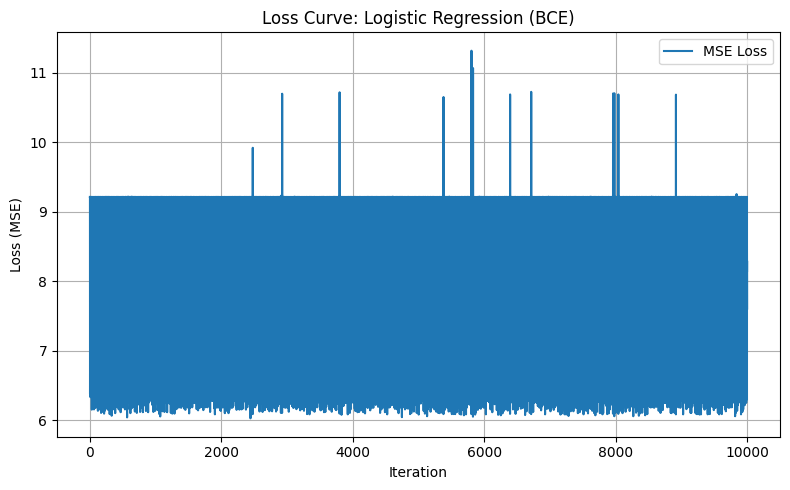

0.5180124223602485

In [81]:
# Train Logistic Regression from scratch
BCEmodel_scratch = LogisticRegressionScratchBCE(learning_rate=1e-3, num_iterations=10000)
BCEmodel_scratch.fit(X_train, y_train)

# Predict and evaluate
BCE_pred_scratch = BCEmodel_scratch.predict(X_test)
BCEmodel_scratch.plot_loss()

score = accuracy_score(y_test, BCE_pred_scratch)
score

## Evaluation

In [82]:
def predict(model):
    model.fit(X_train, y_train)
    model.predict(X_test)
    print(classification_report(y_true=y_test, y_pred=model.predict(x_test)))

In [83]:
BCEmodel_scratch = LogisticRegressionScratchBCE(learning_rate=1e-3, num_iterations=10000)
predict(BCEmodel_scratch)

(5446, 5) (5446, 1)
              precision    recall  f1-score   support

           0       0.92      0.47      0.63       685
           1       0.20      0.78      0.32       120

    accuracy                           0.52       805
   macro avg       0.56      0.62      0.47       805
weighted avg       0.82      0.52      0.58       805



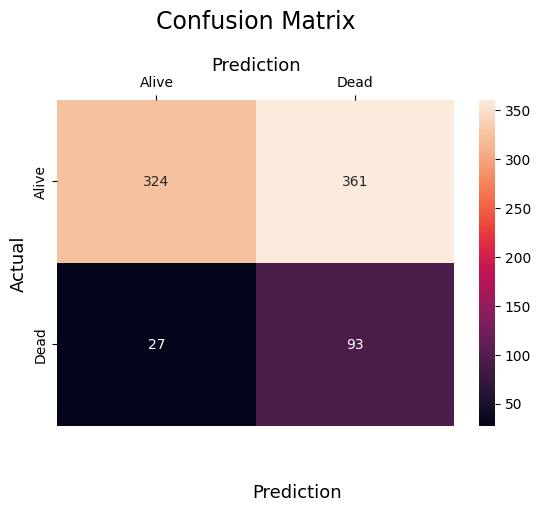

In [84]:
# Confusion matrix
cm = confusion_matrix(y_test, BCE_pred_scratch)

sns.heatmap(
    cm,
    annot=True,
    fmt="g",
    xticklabels=["Alive", "Dead"],
    yticklabels=["Alive", "Dead"],
)
plt.ylabel("Actual", fontsize=13)
plt.title("Confusion Matrix", fontsize=17, pad=20)
plt.gca().xaxis.set_label_position("top")
plt.xlabel("Prediction", fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, "Prediction", ha="center", fontsize=13)
plt.show()

Logistic: ROC AUC=0.720


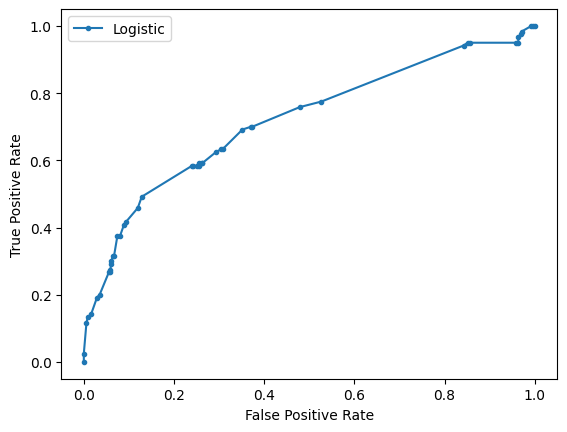

In [85]:
# ROC & AUC

# predict probabilities
lr_probs = BCEmodel_scratch.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, lr_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## Compare to scikit-learn

In [88]:
# Compare to scikit-learn
Model_LR = LogisticRegression()
predict(Model_LR)

# ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1): STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

              precision    recall  f1-score   support

           0       0.92      0.67      0.77       685
           1       0.26      0.68      0.38       120

    accuracy                           0.67       805
   macro avg       0.59      0.67      0.58       805
weighted avg       0.82      0.67      0.72       805



Logistic: ROC AUC=0.716


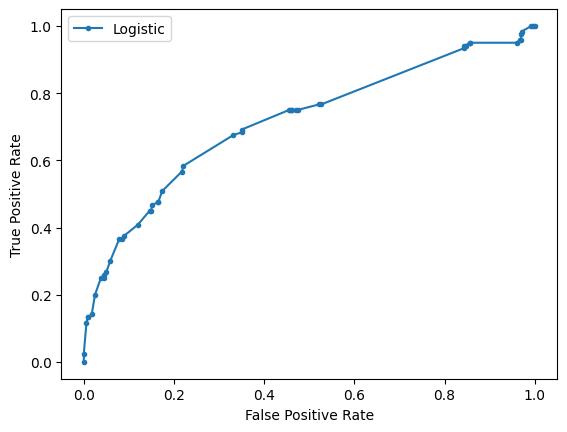

In [87]:
# ROC & AUC
Model_LR = LogisticRegression()
Model_LR.fit(X_train, y_train)
# predict probabilities
lr_probs = Model_LR.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, lr_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()


In [ ]:
# Some comments
from sklearn.metrics import accuracy_score
score = accuracy_score(y, BCE_pred_scratch)
score

"""
How to increase accuracy?

- Medical Ordinal Encoding
- Standard Scaler
- Cross Validation

Clean & validate data (missing values, wrong types, leaks).
Use the right encoding for each column (binary→0/1, ordinal→ordered ints, nominal→one-hot or target/leave-one-out).
Scale numeric features (StandardScaler) — important for LR.
Handle class imbalance (class_weight or resampling/SMOTE).
Add interaction / polynomial features if relationships are non-linear.
Regularize (L1 or L2) and tune C with cross-validation.
Use cross-validation to get reliable performance (not a single train/test).
Evaluate with ROC-AUC, PR-AUC, calibration, confusion matrix (not only accuracy).
If poor signal → feature engineering or new data.
If still weak, try stronger models (tree boosting, ensembles, survival models if time-to-event).
"""

0.4967693836978131